# GAN Training
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from enums import DatasetColumns, WeatherDatasetColumns
from helpers import compare_prediction, evaluate_predictions, find_missing_date_ranges
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, metrics, models, optimizers, regularizers
from tensorflow.keras.models import Model

## Data Preparation
---

In [2]:
# Load data

FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"


original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [3]:
# Gap Dates
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

In [4]:
# Data Splitting
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[:pre_gap_train_size].copy()
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")


pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
pre_weather_data = pre_weather_data.reindex(pre_gap_data.index)
pre_weather_data_test = pre_weather_data.reindex(pre_gap_test.index)


gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()


pre_gap_train_combined = pre_gap_train.join(pre_weather_data[weather_features], how="inner")
pre_gap_test_combined = pre_gap_test.join(pre_weather_data_test[weather_features], how="inner")

## GAN Setup
---

In [5]:
# GAN Hyperparameters
LATENT_DIM = 50
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
EPOCHS = 1000

In [6]:
from tensorflow.keras import layers, models, regularizers


def build_generator(input_dim, output_dim):
    model = models.Sequential(name="Generator")

    # Input layer
    model.add(layers.Dense(512, activation="relu", input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Hidden layers
    model.add(layers.Dense(1024, activation="relu"))  # Increased units
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(
        layers.Dense(output_dim, activation="relu")
    )  # ReLU for non-negative output

    return model


def build_discriminator(input_dim):
    model = models.Sequential(name="Discriminator")

    # Input layer
    model.add(layers.Dense(512, input_dim=input_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Hidden layers
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Additional hidden layer for increased capacity
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(1, activation="sigmoid"))  # Binary classification output

    return model

## Train the Pre gap 
---

In [7]:
combined_columns = [DatasetColumns.PV_YIELD.value] + weather_features
scaler = MinMaxScaler()
pre_gap_scaled = scaler.fit_transform(pre_gap_train_combined[combined_columns])

weather_features_scaled = pre_gap_scaled[:, 1:]  
pv_yield_scaled = pre_gap_scaled[:, :1]  

In [8]:
# Build GAN
generator = build_generator(
    input_dim=LATENT_DIM + weather_features_scaled.shape[1],
    output_dim=pv_yield_scaled.shape[1],
)

discriminator = build_discriminator(
    input_dim=pv_yield_scaled.shape[1] + weather_features_scaled.shape[1]
)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=[metrics.BinaryAccuracy],
)

discriminator.trainable = False
gan_input = layers.Input(shape=(LATENT_DIM + weather_features_scaled.shape[1],))
generated_yield = generator(gan_input)
gan_output = discriminator(
    layers.Concatenate()([generated_yield, gan_input[:, LATENT_DIM:]])
)
gan = Model(gan_input, gan_output)
gan.compile(
    loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=LEARNING_RATE)
)

/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
real_labels = np.ones((len(weather_features_scaled), 1)) 
fake_labels = np.zeros((len(weather_features_scaled), 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(0, 1, (len(weather_features_scaled), LATENT_DIM))
    fake_yield = generator.predict(np.hstack((noise, weather_features_scaled)))

    discriminator.trainable = True
    real_loss = discriminator.train_on_batch(
        np.hstack((pv_yield_scaled, weather_features_scaled)), real_labels
    )
    fake_loss = discriminator.train_on_batch(
        np.hstack((fake_yield, weather_features_scaled)), fake_labels
    )
    d_loss = 0.5 * (real_loss[0] + fake_loss[0])
    d_acc = 0.5 * (real_loss[1] + fake_loss[1])

    discriminator.trainable = False
    g_loss = gan.train_on_batch(
        np.hstack((noise, weather_features_scaled)), real_labels
    )

    # Print progress
    print(
        f"Epoch {epoch + 1}/{EPOCHS} | "
        f"D Loss: {d_loss:.4f}, D Acc: {d_acc:.4f} | G Loss: {g_loss[0]:.4f}"
    )

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
Epoch 1/1000 | D Loss: 0.6898, D Acc: 0.5164 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
Epoch 2/1000 | D Loss: 0.6898, D Acc: 0.5164 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Epoch 3/1000 | D Loss: 0.6898, D Acc: 0.5164 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 4/1000 | D Loss: 0.6898, D Acc: 0.5164 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
Epoch 5/1000 | D Loss: 0.6898, D Acc: 0.5164 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
Epoch 6/1000 | D Loss: 0.6898, D Acc: 0.5163 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
Epoch 7/1000 | D Loss: 0.6898, D Acc: 0.5163 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
Epoch 8/1000 | D Loss: 0.6898, D Acc: 0.5163 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
Epoch 9/1000 | D Loss: 0.6898, D Acc: 0.5163 | G Loss: 0.6898
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 10/1000 | 

: 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
10% of Mean Value (Target MAE/RMSE): 0.021322580645161293
Mean Absolute Error (MAE): 0.17694905103508937
Mean Squared Error (MSE): 0.07858131099066742
Root Mean Squared Error (RMSE): 0.28032358265166957
Mean Absolute Percentage Error (MAPE): 216395605485536.1


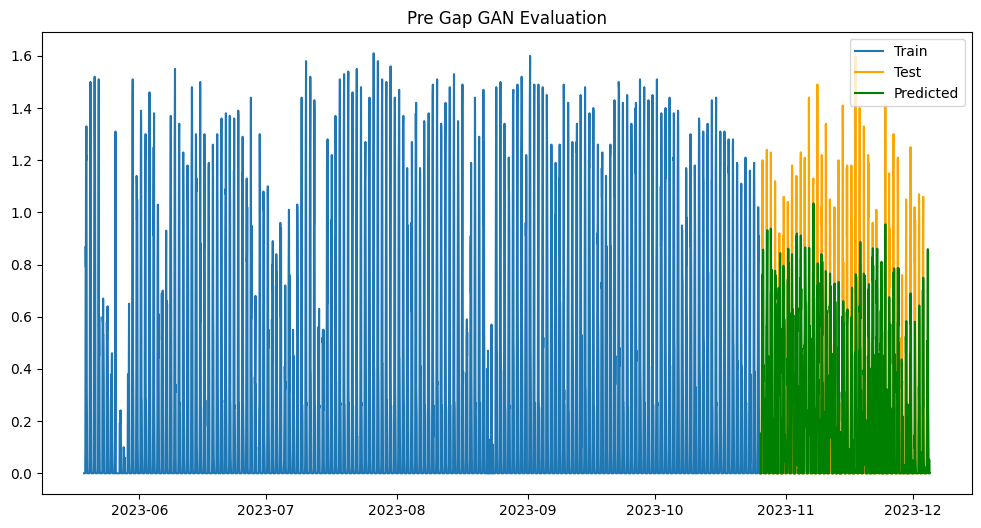

In [16]:
# Test Model
weather_scaler = MinMaxScaler()
weather_scaler.fit(pre_weather_data[weather_features])

test_weather_scaled = weather_scaler.transform(pre_weather_data_test[weather_features])
test_noise = np.random.normal(0, 1, (test_weather_scaled.shape[0], LATENT_DIM))
test_fake_yield_scaled = generator.predict(np.hstack((test_noise, test_weather_scaled)))

test_fake_yield = scaler.inverse_transform(
    np.hstack((test_fake_yield_scaled, test_weather_scaled))
)[:, 0]
true_yield_test = pre_gap_test[DatasetColumns.PV_YIELD.value].values

test_results_df = pd.DataFrame(
    {"True PV Yield": true_yield_test, "Predicted PV Yield": test_fake_yield},
    index=pre_gap_test.index,
)
evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], test_results_df["Predicted PV Yield"])
compare_prediction(
    "Pre Gap GAN Evaluation",
    pre_gap_train[DatasetColumns.PV_YIELD.value],
    pre_gap_test[DatasetColumns.PV_YIELD.value],
    test_results_df["Predicted PV Yield"],
)